In [1]:
import torch
from torchvision.datasets import MNIST
from torchvision import transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
train_data = MNIST(
    root='data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

test_data = MNIST(
    root='data',
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

len(train_data), len(test_data)

(60000, 10000)

In [4]:
train_data, test_data

(Dataset MNIST
     Number of datapoints: 60000
     Root location: data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [195]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [196]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'0 - zero': 0,
 '1 - one': 1,
 '2 - two': 2,
 '3 - three': 3,
 '4 - four': 4,
 '5 - five': 5,
 '6 - six': 6,
 '7 - seven': 7,
 '8 - eight': 8,
 '9 - nine': 9}

In [197]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

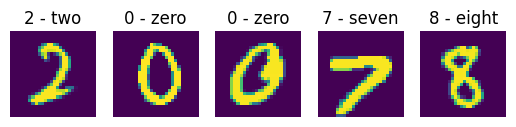

In [198]:
import matplotlib.pyplot as plt
import random

for i, (image, label) in enumerate(random.sample(list(train_data), k=5)):
    plt.subplot(1,5,i+1)
    plt.title(class_names[label])
    plt.imshow(image.squeeze())
    plt.axis(False)

In [199]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

len(train_dataloader), len(test_dataloader)

(1875, 313)

In [200]:
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
    
    def forward(self, x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [201]:
model = TinyVGG(input_shape=1,
                hidden_units=10,
                output_shape=len(class_names))
model

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [202]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [203]:
for X, y in train_dataloader:
    y_pred = model(X)
    print(y.type(torch.float))
    break
    
torch.argmax(torch.softmax(y_pred, dim=1), dim=1).type(torch.float)

tensor([0., 9., 7., 5., 7., 3., 3., 3., 1., 7., 2., 9., 5., 1., 2., 5., 0., 7.,
        2., 8., 8., 5., 5., 5., 7., 1., 4., 7., 5., 7., 6., 5.])


tensor([2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 1., 1., 1.,
        2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [204]:
def train_step(model,
               dataloader,
               loss_fn,
               accuracy_fn,
               optimizer,
               device=device):
    model.train()
    
    train_loss, train_acc = 0, 0
    
    model.to(device)
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    
    return train_loss, train_acc

In [205]:
def test_step(model,
              dataloader,
              loss_fn,
              accuracy_fn,
              device=device):
    model.eval()
    model.to(device)
    test_loss, test_acc = 0, 0
    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            
            test_pred = model(X)
            
            loss = loss_fn(test_pred, y)
            test_loss += loss
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
        
        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")
    
    return test_loss, test_acc

In [206]:
from timeit import default_timer as timer

def calculate_time_run(start_time, end_time):
    return end_time - start_time

In [207]:
from tqdm.auto import tqdm

epochs = 3

results = {'train_loss': [],
           'train_acc': [],
           'test_loss': [],
           'test_acc': []}

start_time = timer()

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       accuracy_fn=accuracy_fn)
    test_loss, test_acc = test_step(dataloader=test_dataloader,
                                    model=model,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn)
    
    results['train_loss'].append(train_loss)
    results['train_acc'].append(train_acc)
    results['test_loss'].append(test_loss)
    results['test_acc'].append(test_acc)

end_time = timer()
calculate_time_run(start_time, end_time)

  0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.26071 | Train accuracy: 91.50%
Test loss: 0.07879 | Test accuracy: 97.40%

Train loss: 0.06751 | Train accuracy: 97.94%
Test loss: 0.04841 | Test accuracy: 98.35%

Train loss: 0.05239 | Train accuracy: 98.40%
Test loss: 0.03665 | Test accuracy: 98.78%



47.31200810003793

In [227]:
!pip install torchinfo

In [231]:
from torchinfo import summary

summary(model=model,
        input_size=(32,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 10]                  --
├─Sequential: 1-1                        [32, 10, 14, 14]          --
│    └─Conv2d: 2-1                       [32, 10, 28, 28]          100
│    └─ReLU: 2-2                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-3                       [32, 10, 28, 28]          910
│    └─ReLU: 2-4                         [32, 10, 28, 28]          --
│    └─MaxPool2d: 2-5                    [32, 10, 14, 14]          --
├─Sequential: 1-2                        [32, 10, 7, 7]            --
│    └─Conv2d: 2-6                       [32, 10, 14, 14]          910
│    └─ReLU: 2-7                         [32, 10, 14, 14]          --
│    └─Conv2d: 2-8                       [32, 10, 14, 14]          910
│    └─ReLU: 2-9                         [32, 10, 14, 14]          --
│    └─MaxPool2d: 2-10                   [32, 10, 7, 7]            --
├─Sequentia

In [226]:
image, label = random.choice(list(test_data))
image, label = image.to(device), label
pred = model(image.unsqueeze(0))
pred, label

(tensor([[ 3.0606, -2.5365, -2.7394, -4.8815,  3.4581, -1.5072, 12.5661, -5.1723,
           0.6944, -2.9151]], device='cuda:0', grad_fn=<AddmmBackward0>),
 6)

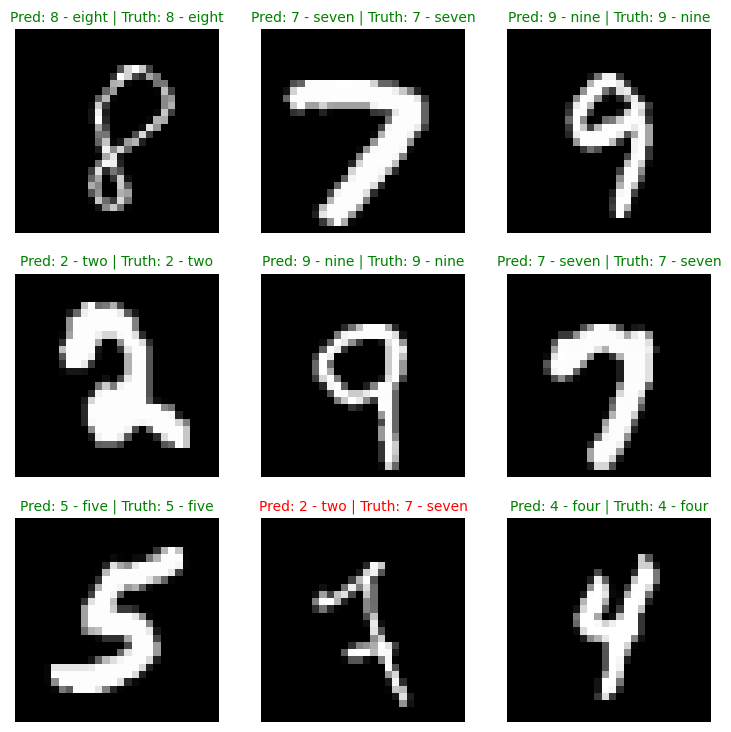

In [216]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(random.sample(list(test_data), k = nrows * ncols)):
    image, label = sample
    pred = model(image.unsqueeze(0).to(device))
    pred_classes = torch.softmax(pred, dim=1).argmax(dim=1)
    # Create a subplot
    plt.subplot(nrows, ncols, i+1)

    # Plot the target image
    plt.imshow(image.squeeze(), cmap="gray")

    # Find the prediction label (in text form, e.g. "Sandal")
    pred_label = class_names[pred_classes]

    # Get the truth label (in text form, e.g. "T-shirt")
    truth_label = class_names[label] 

    # Create the title text of the plot
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    
    # Check for equality and change title colour accordingly
    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False);